In [ ]:
from IPython.core.display import display, HTML, Markdown
import matplotlib.pyplot as plt
import pandas as pd
import dateparser
import seaborn as sns
from tqdm import tqdm

pd.set_option('display.max_rows', 100)

display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
%matplotlib inline

In [183]:
df_states = pd.read_csv("covid-19-data/us-states.csv")
df_states.rename(columns={"cases": "total_cases"}, inplace=True)
df_counties = pd.read_csv("covid-19-data/us-counties.csv")
df_counties.rename(columns={"cases": "total_cases"}, inplace=True)

In [186]:
df_counties.loc[(df_counties.county == 'New York City') &
                (df_counties.state == 'New York'), 'fips'] = 36061

In [218]:
# Read population data
df_population = pd.read_csv("co-est2019-alldata.csv.gz", encoding = "ISO-8859-1" )
df_population['fips'] = df_population.apply(lambda x: f"{x.STATE}{x.COUNTY:03}", axis=1)
fips_to_pop = dict(zip(df_population.fips.astype(int), df_population.POPESTIMATE2019))

In [ ]:
df

In [193]:
def calc(df):
    df['new_cases'] = df.groupby('fips')['total_cases'].diff()

In [194]:
calc(df_counties)
calc(df_states)

In [195]:
fips_to_state= {k:v for d in list(df_states.groupby(["state"]).first().apply(lambda x: {x.fips: x.name}, axis=1)) for k, v in d.items()}
state_to_fips= {k:v for d in list(df_states.groupby(["state"]).first().apply(lambda x: {x.name: x.fips}, axis=1)) for k, v in d.items()}

In [196]:
fips_to_county= {k:v for d in list(df_counties.groupby(["county", "state"]).first().apply(lambda x: {x.fips: x.name}, axis=1)) for k, v in d.items()}
county_to_fips= {k:v for d in list(df_counties.groupby(["county", "state"]).first().apply(lambda x: {x.name: x.fips}, axis=1)) for k, v in d.items()}

# Overview

The New York Times publishes their Covid-19 dataset daily to github here: `https://github.com/nytimes/covid-19-data.git`

This notebook was inspired by the Minute Physics YouTube video: https://www.youtube.com/watch?v=54XLXg4fYsc

I wanted to recreate at the local county level the plots that are shown on this site: https://aatishb.com/covidtrends/

# Plots

In [ ]:
# Aatish B's log log plot
def ll_plot(df, geos, xlim=None, max_pop=None):
    ax = plt.gca()
    for geo in geos:
        if isinstance(geo, tuple):
            fip = county_to_fips[geo]
            label = f"{geo[0]}, {geo[1]}"
        else:
            fip = state_to_fips[geo]
            label = geo
        df.query(f"fips=={fip}").plot(
            x='total_cases', y='new_cases', label=label, ax=ax)
    plt.yscale("log")
    plt.xscale("log")
    plt.ylabel("Daily New Cases")
    if xlim:
        plt.xlim(1, xlim)
    if max_pop:
        ax.plot([max_pop[1], max_pop[1]], [1, 1e6],
                color="red", linestyle="--")
        ax.text(max_pop[1]*.75, 1e1, f"{max_pop[0]} Population", rotation=90)

In [ ]:
def decade_time(county, state, end_value=None):
    df=df_counties
    state = state.replace("'", "\\'")
    county = county.replace("'", "\\'")

    if not end_value:
        end_value = df.query(f"state=='{state}' and county=='{county}'").total_cases.max()
    try:
        x = df.query(f"state=='{state}' and county=='{county}' and total_cases<{end_value}").iloc[-1].date
        y = df.query(f"state=='{state}' and county=='{county}' and total_cases<{end_value/10}").iloc[-1].date
        xd = dateparser.parse(x)
        yd = dateparser.parse(y)
        delta = xd - yd
    except IndexError:
        return None
    return delta.days

The `log-log` plot does not show time and one might wonder how long does it take for the total cases to increase by a factor of 10x. (I called this " _decade time_ " ).
In each county, for each day compute how many days have elapsed since the total number of cases was 1/10 the current total number of cases.

Social distancing should be slowing the rate at which the total cases are growing.
We calculate the _decade time_ for every day and for every county.

**Note that this calculation may take more than 5 minutes to complete**

In [ ]:
tqdm.pandas()
if 'decade_time' not in df_counties.columns:
    df_counties['decade_time'] = df_counties.progress_apply(lambda row: decade_time(row.county, row.state, row.total_cases), axis=1)

## State Plots

In [ ]:
ll_plot(df_states.query("total_cases>50"), geos=[
    'California',
    'New York',
    'Washington',
    'Colorado',
    "Michigan"
])

In [202]:
def plot_county(county, state):
    fips = county_to_fips[(county, state)]
    pop = fips_to_pop[fips]
    display(Markdown(f"## {county}, {state}"))
    ll_plot(df_counties.query("total_cases > 50"),
           geos=[(county, state)],
           max_pop=(county, pop)
           )
    display(Markdown(f"{county}'s current decade time is {decade_time(county, state)} days"))
    display(Markdown(f"{county}'s population {pop/1e6:.2f} million"))

## New York City, New York

New York City's current decade time is 11 days

New York City's population 1.63 million

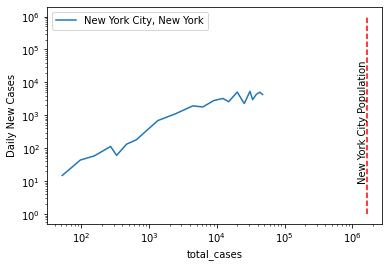

In [203]:
plot_county("New York City", "New York")

In [204]:
county_to_fips['New York City', 'New York']

36061.0

## Boulder, Colorado

Boulder's current decade time is 12 days

Boulder's population 0.33 million

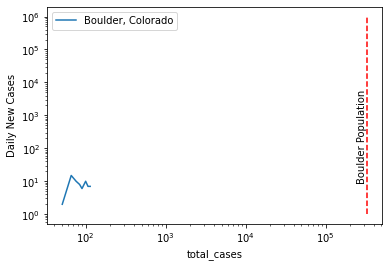

In [205]:
plot_county('Boulder', 'Colorado')

## Wayne, Michigan

Wayne's current decade time is 10 days

Wayne's population 1.75 million

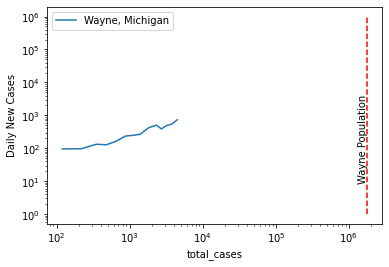

In [206]:
plot_county('Wayne', 'Michigan')

## Santa Clara, California

Santa Clara's current decade time is 17 days

Santa Clara's population 1.93 million

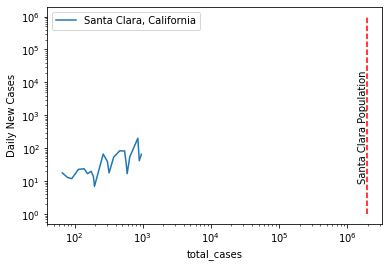

In [207]:
plot_county('Santa Clara', 'California')

## Suffolk, New York

Suffolk's current decade time is 10 days

Suffolk's population 1.48 million

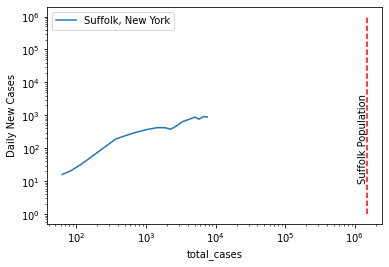

In [208]:
plot_county('Suffolk', 'New York')

## Passaic, New Jersey

Passaic's current decade time is 8 days

Passaic's population 0.50 million

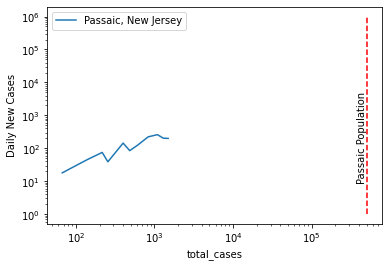

In [209]:
plot_county('Passaic', 'New Jersey')

# Tables of "Decade Times"

In [210]:
def show_decade(county, state, tail=14):
    display(Markdown(f"## {county} {state} Decade Times (Past Two Weeks)"))
    display(df_counties.query(f"state=='{state}' and county=='{county}'").tail(tail))

In [211]:
show_decade('Boulder', 'Colorado')

## Boulder Colorado Decade Times (Past Two Weeks)

,date,county,state,fips,total_cases,deaths,new_cases
4488,2020-03-19,Boulder,Colorado,8013.0,11,0,3.0
5263,2020-03-20,Boulder,Colorado,8013.0,24,0,13.0
6186,2020-03-21,Boulder,Colorado,8013.0,30,0,6.0
7221,2020-03-22,Boulder,Colorado,8013.0,37,0,7.0
8364,2020-03-23,Boulder,Colorado,8013.0,39,0,2.0
9608,2020-03-24,Boulder,Colorado,8013.0,49,0,10.0
10984,2020-03-25,Boulder,Colorado,8013.0,51,0,2.0
12535,2020-03-26,Boulder,Colorado,8013.0,66,0,15.0
14213,2020-03-27,Boulder,Colorado,8013.0,76,1,10.0
16007,2020-03-28,Boulder,Colorado,8013.0,84,1,8.0


In [212]:
show_decade('Weld', 'Colorado')

## Weld Colorado Decade Times (Past Two Weeks)

,date,county,state,fips,total_cases,deaths,new_cases
4506,2020-03-19,Weld,Colorado,8123.0,9,1,0.0
5284,2020-03-20,Weld,Colorado,8123.0,15,1,6.0
6211,2020-03-21,Weld,Colorado,8123.0,21,1,6.0
7247,2020-03-22,Weld,Colorado,8123.0,37,2,16.0
8393,2020-03-23,Weld,Colorado,8123.0,50,2,13.0
9640,2020-03-24,Weld,Colorado,8123.0,76,2,26.0
11017,2020-03-25,Weld,Colorado,8123.0,87,4,11.0
12571,2020-03-26,Weld,Colorado,8123.0,107,4,20.0
14251,2020-03-27,Weld,Colorado,8123.0,129,6,22.0
16046,2020-03-28,Weld,Colorado,8123.0,161,7,32.0


In [213]:
show_decade('Santa Clara', 'California', tail=14)

## Santa Clara California Decade Times (Past Two Weeks)

,date,county,state,fips,total_cases,deaths,new_cases
4477,2020-03-19,Santa Clara,California,6085.0,189,6,14.0
5252,2020-03-20,Santa Clara,California,6085.0,196,8,7.0
6173,2020-03-21,Santa Clara,California,6085.0,263,8,67.0
7207,2020-03-22,Santa Clara,California,6085.0,303,11,40.0
8350,2020-03-23,Santa Clara,California,6085.0,321,11,18.0
9594,2020-03-24,Santa Clara,California,6085.0,375,17,54.0
10969,2020-03-25,Santa Clara,California,6085.0,459,18,84.0
12520,2020-03-26,Santa Clara,California,6085.0,542,20,83.0
14197,2020-03-27,Santa Clara,California,6085.0,574,21,32.0
15990,2020-03-28,Santa Clara,California,6085.0,591,26,17.0


In [214]:
show_decade('Suffolk', 'New York')

## Suffolk New York Decade Times (Past Two Weeks)

,date,county,state,fips,total_cases,deaths,new_cases
4889,2020-03-19,Suffolk,New York,36103.0,178,3,62.0
5740,2020-03-20,Suffolk,New York,36103.0,371,7,193.0
6735,2020-03-21,Suffolk,New York,36103.0,662,9,291.0
7831,2020-03-22,Suffolk,New York,36103.0,1034,12,372.0
9031,2020-03-23,Suffolk,New York,36103.0,1458,13,424.0
10343,2020-03-24,Suffolk,New York,36103.0,1880,13,422.0
11784,2020-03-25,Suffolk,New York,36103.0,2260,20,380.0
13397,2020-03-26,Suffolk,New York,36103.0,2735,22,475.0
15141,2020-03-27,Suffolk,New York,36103.0,3385,22,650.0
16982,2020-03-28,Suffolk,New York,36103.0,4138,37,753.0


# Calculate Decade Time For All Counties

In [215]:
county_decade_time = {}
for k in tqdm(county_to_fips.keys()):
    county_decade_time[k] = decade_time(k[0], k[1])

100%|██████████| 2248/2248 [00:21<00:00, 104.65it/s]


In [96]:
df_decade = pd.DataFrame.from_dict({"county":list(county_decade_time.keys()), "dec_time": list(county_decade_time.values())})

In [216]:
display(Markdown(f"## 20 Worst Counties"))
df_decade.sort_values('dec_time', ascending=True).reset_index(drop=True).head(20)

## 20 Worst Counties

,county,dec_time
0,"(Unknown, Missouri)",0.0
1,"(Unknown, Utah)",1.0
2,"(Hopkins, Kentucky)",2.0
3,"(Jefferson, Ohio)",3.0
4,"(Darke, Ohio)",3.0
5,"(Lawrence, Pennsylvania)",4.0
6,"(St. Lawrence, New York)",4.0
7,"(Iberia, Louisiana)",4.0
8,"(Taylor, Texas)",4.0
9,"(Camden, Missouri)",4.0


In [217]:
display(Markdown(f"## 10 Best Counties"))
df_decade.sort_values('dec_time', ascending=False).reset_index(drop=True).head(10)

## 10 Best Counties

,county,dec_time
0,"(Solano, California)",34.0
1,"(Douglas, Nebraska)",26.0
2,"(Johnson, Iowa)",22.0
3,"(Kittitas, Washington)",22.0
4,"(Harrison, Kentucky)",22.0
5,"(King, Washington)",20.0
6,"(Lancaster, South Carolina)",20.0
7,"(Snohomish, Washington)",19.0
8,"(Fond du Lac, Wisconsin)",19.0
9,"(Forrest, Mississippi)",19.0


## Decade Plots

In [78]:
counties = [
    ('Boulder', 'Colorado'),
    ('Santa Clara', 'California'),
    ('Suffolk', 'New York'),
    ('Passaic', 'New Jersey')
]

In [79]:
def decade_plot(counties):
    fips = [county_to_fips[x] for x in counties]
    g = sns.lineplot(x='date',
                     y='decade_time',
                     hue='county',
                     data=df_counties[df_counties.fips.isin(fips)])
    x=plt.xticks(rotation=55)
    for i, label in enumerate(g.xaxis.get_ticklabels()):
        if i%5==0:
            label.set_visible(True)
        else:
            label.set_visible(False)

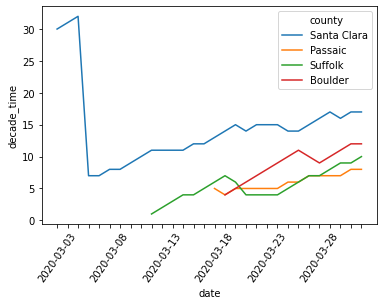

In [80]:
decade_plot(counties)

In [140]:
[x for x in df_population.columns if "pop" in x.lower()]
cols = ['STATE', 'COUNTY', 'STNAME', 'CTYNAME', 'POPESTIMATE2019', 'fips']

In [159]:
df_population['fips'] = df_population.apply(lambda x: f"{x.STATE}{x.COUNTY:03}", axis=1)
fips_to_pop = dict(zip(df_population.fips.astype(int), df_population.POPESTIMATE2019))